# Analysis of GWL projections

In [1]:
#import libraries
%matplotlib notebook
import geopandas as gpd
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
from functions import setinputdataset
#from statsmodels.tsa.seasonal import seasonal_decompose
#from scipy.stats import linregress
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from functions import mapplots
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pymannkendall as mk
from matplotlib.colors import LinearSegmentedColormap
import importlib

In [2]:
path=r"D:\Data\students\mariana\codes\GW_forecasting_ML\projections/"
#list of wells with NSE>0.5 and r2>0.6
well_list = pd.read_csv(path+"/well_list60.txt")

#Name of climate model projections available (given by the DWD)
Proj_names=["MPI_WRF361H", "MPI_CCLM", "MIROC_CCLM", 
         "HadGEM_WRF361H", "ECE_RACMO_r12", "ECE_RACMO_r1"]
#Import spatial information per well -- results of the Accuracy_plot script
gw_sel_int=gpd.read_file("D:/Data/students/mariana/data/SHP/gw_sel_int.shp")
gw_sel_proj=gw_sel_int.loc[gw_sel_int.MEST_ID.isin(well_list.MEST_ID)]

<IPython.core.display.Javascript object>


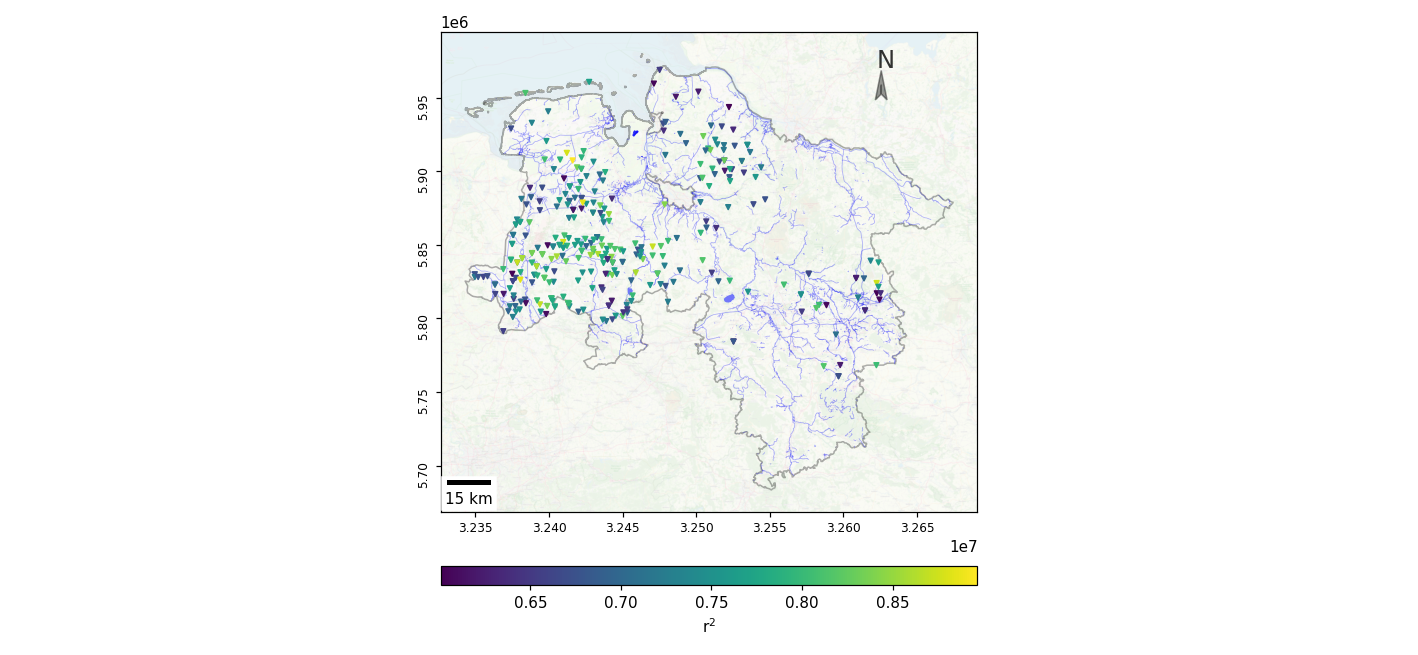

In [7]:
#Administrative boundaries
germany_states = gpd.read_file("D:/Data/students/mariana/data/SHP/DEU_adm1.shp")
ND=germany_states[germany_states.NAME_1== "Niedersachsen"]
waterbodies=gpd.read_file("D:/Data/students/mariana/data/SHP/waterbodiesND.shp")
waterways=gpd.read_file("D:/Data/students/mariana/data/SHP/waterwaysND.shp")


#project coordinate sytem
proj_coor=4647
gw_sel_proj=gw_sel_proj.to_crs(epsg=proj_coor)
waterbodies=waterbodies.to_crs(epsg=proj_coor)
waterways=waterways.to_crs(epsg=proj_coor)
bound=germany_states.to_crs(gw_sel_proj.crs.to_string()) 
ND=ND.to_crs(epsg=proj_coor)

cmap="viridis"

fig, gw = plt.subplots(ncols=1, figsize=(13, 6))
gw=mapplots(column='r2_2',cmap=cmap,bound=bound,axs=gw,gw_s=gw_sel_proj,
            waterbodies=waterbodies,waterways=waterways,ND=ND,normalize=True)

#gw2=mapplots(column='FOK',cmap=cmap,bound=bound,axs=gw2)
plt.tight_layout()    
#plt.savefig(pathfig+"PT.pdf")

## Load GWL projections

In [8]:
count=0
gw_sel_projr=gw_sel_proj.reset_index()

for pjname in Proj_names:
    gw_sel_projr[pjname+'_scores']=np.zeros(len(gw_sel_projr))
    prdfs=[]
    for wellid in well_list.MEST_ID:
        projgwl=pd.read_csv(path+'/'+str(wellid)+'/'+'ensemble_mean_values_CNN_'
                            +str(wellid)+'_'+pjname+'.txt', sep=';')
        projgwl.index=pd.to_datetime(projgwl['dates'])
        scores=pd.read_csv(path+'/'+str(wellid)+'/'+pjname+'_scores.txt', sep=',')
        
        iwell=gw_sel_projr.loc[gw_sel_projr.MEST_ID==wellid].index[0]
        
        # select only R2 to check the projections
        gw_sel_projr.at[iwell,pjname+'_scores']=round(scores.R2.values[0],3) 
        prdfs.append(projgwl)
    
    df=pd.DataFrame({'wellids':well_list.MEST_ID, pjname+'_proj': prdfs})
    gw_sel_projr[pjname+'_proj']=df[pjname+'_proj'].copy()        
    

## Plot correlation between GWL observations and projections

<IPython.core.display.Javascript object>


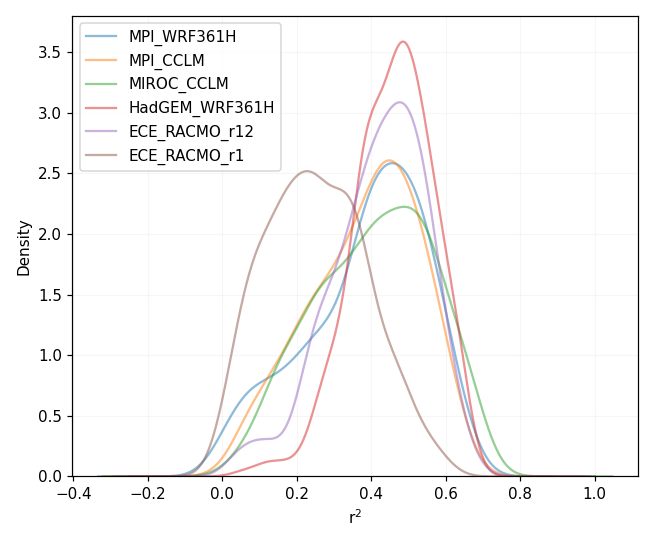

In [14]:
plt.figure(figsize=(6,5))
for pjname in Proj_names:
    gw_sel_projr[pjname+'_scores'].plot.kde(label=pjname,alpha=0.5)
plt.ylim([0,3.8])
plt.xlabel('r$^2$')
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()


In [ ]:
fig, gw = plt.subplots(nrows=2,ncols=1, sharex=False, figsize=(13, 16))
gw[0,0]=mapplots(column='HadGEM_WRF361H_scores',cmap='viridis',bound=bound,axs=gw[0,0],gw_s=gw_sel_proj,
            waterbodies=waterbodies,waterways=waterways,ND=ND)
gw[0,1]=mapplots(column='ECE_RACMO_r12_scores',cmap='viridis',bound=bound,axs=gw[0,1],gw_s=gw_sel_proj,
            waterbodies=waterbodies,waterways=waterways,ND=ND)
#gw[1,0]=mapplots(column='MPI_CCLM_scores',cmap='viridis',bound=bound,axs=gw[1,0],gw_s=gw_sel_proj,
#            waterbodies=waterbodies,waterways=waterways,ND=ND)
#gw[1,1]=mapplots(column='MPI_WRF361H_scores',cmap='viridis',bound=bound,axs=gw[1,1],gw_s=gw_sel_proj,
#            waterbodies=waterbodies,waterways=waterways,ND=ND)

#gw2=mapplots(column='FOK',cmap=cmap,bound=bound,axs=gw2)
plt.tight_layout()    
#plt.savefig(pathfig+"PT.pdf")

<IPython.core.display.Javascript object>


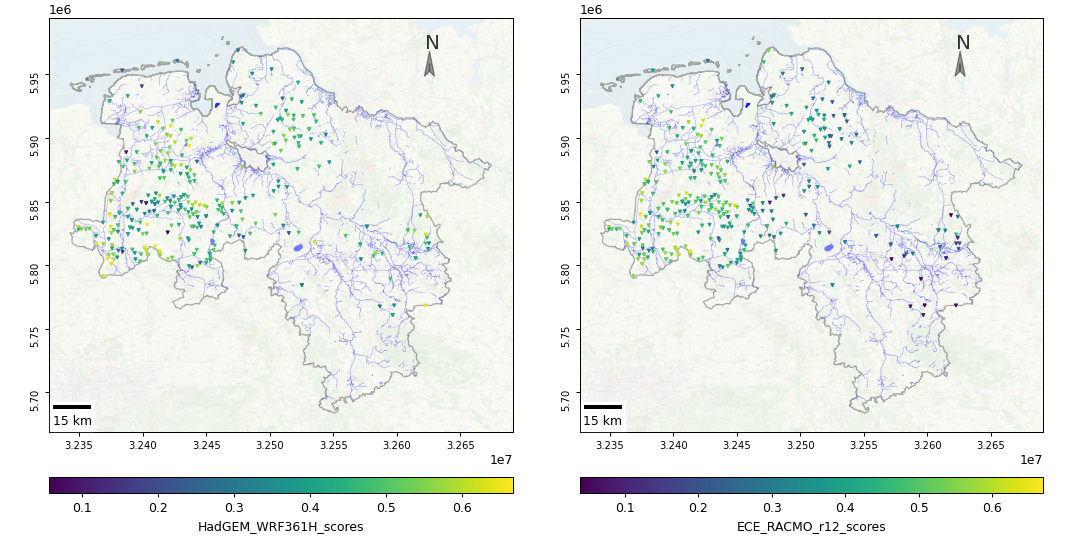

In [209]:
fig, (gw,gw2) = plt.subplots(nrows=1,ncols=2, sharex=False, figsize=(12, 6))
gw=mapplots(column='HadGEM_WRF361H_scores',cmap='viridis',bound=bound,axs=gw,gw_s=gw_sel_proj,
            waterbodies=waterbodies,waterways=waterways,ND=ND)
gw2=mapplots(column='ECE_RACMO_r12_scores',cmap='viridis',bound=bound,axs=gw2,gw_s=gw_sel_proj,
            waterbodies=waterbodies,waterways=waterways,ND=ND)
#gw[1,0]=mapplots(column='MPI_CCLM_scores',cmap='viridis',bound=bound,axs=gw[1,0],gw_s=gw_sel_proj,
#            waterbodies=waterbodies,waterways=waterways,ND=ND)
#gw[1,1]=mapplots(column='MPI_WRF361H_scores',cmap='viridis',bound=bound,axs=gw[1,1],gw_s=gw_sel_proj,
#            waterbodies=waterbodies,waterways=waterways,ND=ND)

#gw2=mapplots(column='FOK',cmap=cmap,bound=bound,axs=gw2)
plt.tight_layout()    
#plt.savefig(pathfig+"PT.pdf")

## Trend

__Mann-Kendall test__ -- for seasonal time series\
-_trend_: tells the trend (increasing, decreasing or no trend)\
-_h_: True (if trend is present) or False (if the trend is absence)\
-_p_: p-value of the significance test\
-_z_: normalized test statistics\
-_Tau_: Kendall Tau\
-_s_: Mann-Kendal's score\
-_var_s_: Variance S\
-_slope_: Theil-Sen estimator/slope\
-_intercept_: intercept of Kendall-Theil Robust Line, for seasonal test, full period cycle consider as unit time step

Hussain et al., (2019). pyMannKendall: a python package for non parametric Mann Kendall family of trend tests.. Journal of Open Source Software, 4(39), 1556, https://doi.org/10.21105/joss.01556

In [16]:
datei=pd.to_datetime('01012021', format='%d%m%Y')
datem=pd.to_datetime('01012070', format='%d%m%Y')
datef=gw_sel_projr[pjname+'_proj'][0].Sim.index[-1]
deltmonthsnf=(datem.month-datei.month)+(datem.year-datei.year)*12
deltmonthsff=(datef.month-datem.month)+(datef.year-datem.year)*12


In [117]:
period=12
alpha=0.05
for pjname in Proj_names:
    
    gw_sel_projr[pjname+'_slopenf']=np.zeros(len(gw_sel_projr))
    gw_sel_projr[pjname+'_trendnf']=np.zeros(len(gw_sel_projr))
    gw_sel_projr[pjname+'_pvalnf']=np.zeros(len(gw_sel_projr))
    gw_sel_projr[pjname+'_deltanf']=np.zeros(len(gw_sel_projr)) 
    gw_sel_projr[pjname+'_slopeff']=np.zeros(len(gw_sel_projr))
    gw_sel_projr[pjname+'_trendff']=np.zeros(len(gw_sel_projr))
    gw_sel_projr[pjname+'_pvalff']=np.zeros(len(gw_sel_projr)) 
    gw_sel_projr[pjname+'_deltaff']=np.zeros(len(gw_sel_projr)) 
    
    
    for i in range(len(gw_sel_projr[pjname+'_proj'])):
        dfproj=gw_sel_projr[pjname+'_proj'][i].Sim
        nearfuture=dfproj.loc[(dfproj.index>datei)&
                              (dfproj.index<datem)]
        farfuture=dfproj.loc[dfproj.index>datem]
        overlap=dfproj.loc[(dfproj.index<datei)]
        overlapff=dfproj.loc[(dfproj.index>pd.to_datetime('01012055', format='%d%m%Y')) 
                             & (dfproj.index<datem)]


        #Seasonal Mann-Kendall test also developed to remove the effect of seasonality
        trendnf, hnf, pnf, znf, Taunf, snf, var_snf, slopenf, interceptnf =mk.seasonal_test(nearfuture, period=period, 
                                                                         alpha=alpha)
        trendff, hff, pff, zff, Tauff, sff, var_sff, slopeff, interceptff =mk.seasonal_test(farfuture, period=period, 
                                                                         alpha=alpha)
        
        gw_sel_projr.at[i,pjname+'_slopenf']=slopenf
        gw_sel_projr.at[i,pjname+'_trendnf']=trendnf
        gw_sel_projr.at[i,pjname+'_pvalnf']=pnf
        gw_sel_projr.at[i,pjname+'_deltanf']=(slopenf*deltmonthsnf)/np.abs(overlap.mean())*100
        
        gw_sel_projr.at[i,pjname+'_slopeff']=slopeff
        gw_sel_projr.at[i,pjname+'_trendff']=trendff
        gw_sel_projr.at[i,pjname+'_pvalff']=pff     
        gw_sel_projr.at[i,pjname+'_deltaff']=(slopeff*deltmonthsff)/np.abs(overlapff.mean())*100

        #print(trendnf,trendff)

In [391]:
cmdfs=gw_sel_projr[['ECE_RACMO_r12_deltanf','ECE_RACMO_r12_deltanf','HadGEM_WRF361H_deltanf',
                            'MPI_WRF361H_deltanf', 'MPI_CCLM_deltanf',
                              'MIROC_CCLM_deltanf','ECE_RACMO_r12_deltaff',
                              'ECE_RACMO_r12_deltaff',
                              'HadGEM_WRF361H_deltaff','MPI_WRF361H_deltaff',
                              'MPI_CCLM_deltaff', 'MIROC_CCLM_deltaff']]

l1=cmdfs.where(cmdfs<-100).dropna(axis=0, how='all').index
l2=cmdfs.where(cmdfs>100).dropna(axis=0, how='all').index
lind=l1.append(l2).unique()
gw_sel_projrc=gw_sel_projr.drop(index=lind)

In [313]:
data=gw_sel_projrc[['ECE_RACMO_r12_deltanf','ECE_RACMO_r12_deltanf','HadGEM_WRF361H_deltanf',
                  'MPI_WRF361H_deltanf','MPI_CCLM_deltanf','MIROC_CCLM_deltanf',
                                   'ECE_RACMO_r12_deltaff','ECE_RACMO_r12_deltaff','HadGEM_WRF361H_deltaff',
                  'MPI_WRF361H_deltaff','MPI_CCLM_deltaff','MIROC_CCLM_deltaff']]
plt.figure()
#sns.violinplot(data=data, inner=None, linewidth=0.5)
sns.histplot(data=data)

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Count'>

<IPython.core.display.Javascript object>


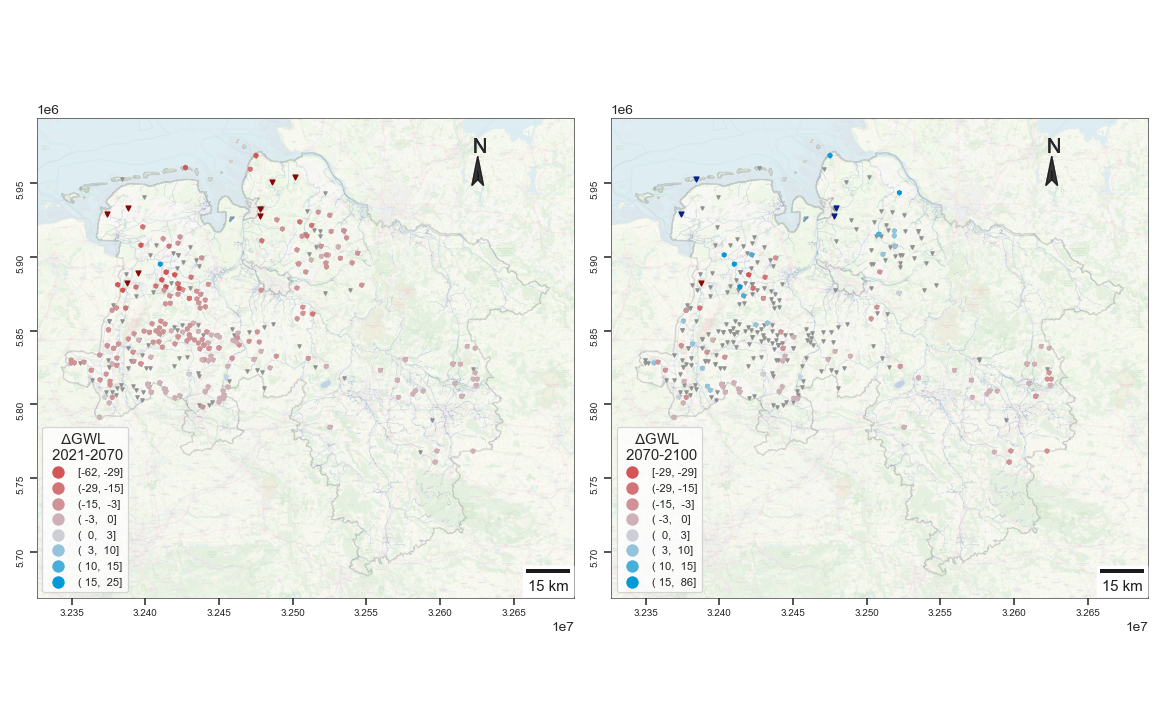

In [725]:
#proj='HadGEM_WRF361H'
proj='ECE_RACMO_r12'
importlib.reload(plt); importlib.reload(sns)
#sns.set_style("ticks")

l1nf=gw_sel_projr[proj+'_deltanf'].where(gw_sel_projr[proj+'_deltanf']<-100).dropna(axis=0, how='all').index
l2nf=gw_sel_projr[proj+'_deltanf'].where(gw_sel_projr[proj+'_deltanf']>100).dropna(axis=0, how='all').index
l1ff=gw_sel_projr[proj+'_deltaff'].where(gw_sel_projr[proj+'_deltaff']<-100).dropna(axis=0, how='all').index
l2ff=gw_sel_projr[proj+'_deltaff'].where(gw_sel_projr[proj+'_deltaff']>100).dropna(axis=0, how='all').index

#keep only the wells that are below -100
gw_sel_projrcnf1=gw_sel_projr.iloc[l1nf]
gw_sel_projrcnf2=gw_sel_projr.iloc[l2nf]
#keep only the wells that are above 100
gw_sel_projrcff1=gw_sel_projr.iloc[l1ff]
gw_sel_projrcff2=gw_sel_projr.iloc[l2ff]

gw_sel_projrcnf=gw_sel_projrc.loc[gw_sel_projrc[proj+'_trendnf']!='no trend']
gw_sel_projrcff=gw_sel_projrc.loc[gw_sel_projrc[proj+'_trendff']!='no trend']
cmap = LinearSegmentedColormap.from_list( 'mycmap', [(0, '#d35555'),(0.6, '#cdd5dd'), (1, '#009ad8')])

max_of_min=max(gw_sel_projrcff[proj+'_deltaff'].min(), gw_sel_projrcnf[proj+'_deltanf'].min() )
minlim=-30 if max_of_min< -30 else max_of_min
classification_kwds=dict(bins=[minlim,-15,-3,0,3,10,15])
legend_kwds={'loc': 3, 'fmt':"{:.0f}",'interval': True, 'fontsize':9}

fig, (gw,gw2) = plt.subplots(nrows=1,ncols=2, sharex=False, figsize=(13, 8),linewidth=0.01)
gw=mapplotsmod(column=proj+'_deltanf',bound=bound,axs=gw,gw_s=gw_sel_projrcnf, scheme='User_Defined',
            waterbodies=waterbodies,waterways=waterways,ND=ND, cmap=cmap, marker='h' ,colorbar=False, normalize=False,
              classification_kwds=classification_kwds, markersize=12, 
               legend_title='   $\Delta$GWL \n 2021-2070',legend_kwds=legend_kwds)
gw=mapplotsmod(column=proj+'_deltanf',color='#939393',
               bound=bound,axs=gw,gw_s=gw_sel_projr, marker='v',markersize=7,zorder=1)
gw=mapplotsmod(column=proj+'_deltanf',color='#8a0808',
               bound=bound,axs=gw,gw_s=gw_sel_projrcnf1, marker='v',markersize=16, label='>100%')
gw=mapplotsmod(column=proj+'_deltanf',color='#08208a',
               bound=bound,axs=gw,gw_s=gw_sel_projrcnf2, marker='v',markersize=16)

[gw.spines[axis].set_linewidth(0.5) for axis in ['top', 'bottom', 'left', 'right']]

gw2=mapplotsmod(column=proj+'_deltaff',bound=bound,axs=gw2,gw_s=gw_sel_projrcff,scheme='User_Defined',
            waterbodies=waterbodies,waterways=waterways,ND=ND, cmap=cmap, marker='h' ,colorbar=False, normalize=False,
              classification_kwds=classification_kwds, markersize=12,  
                legend_title='   $\Delta$GWL \n 2070-2100',legend_kwds=legend_kwds )
gw2=mapplotsmod(column=proj+'_deltaff',color='#939393',
               bound=bound,axs=gw2,gw_s=gw_sel_projr, marker='v',markersize=7,zorder=1)
gw2=mapplotsmod(column=proj+'_deltaff',color='#8a0808',
                bound=bound,axs=gw2,gw_s=gw_sel_projrcff1, marker='v',markersize=16,label='>100%')
gw2=mapplotsmod(column=proj+'_deltaff',color='#08208a',
                bound=bound,axs=gw2,gw_s=gw_sel_projrcff2, marker='v',markersize=16,label='<100%')
[gw2.spines[axis].set_linewidth(0.5) for axis in ['top', 'bottom', 'left', 'right']]
plt.tight_layout() 
plt.savefig(path+proj+"_delta_Ext.png",bbox_inches="tight")

<IPython.core.display.Javascript object>


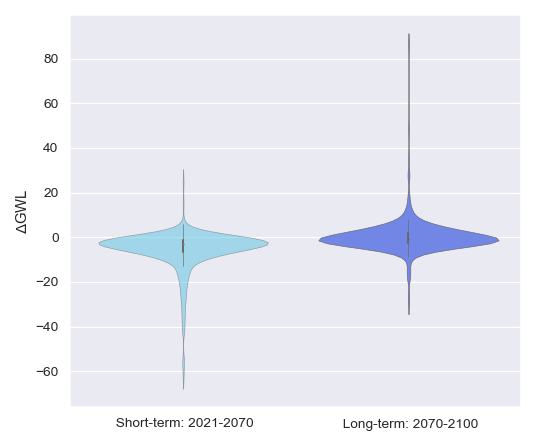

In [726]:
data=gw_sel_projrc[[proj+'_deltanf',proj+'_deltaff']]
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(6,5))
colors = ['#5ed5f8', '#5e7af8']
ax = sns.violinplot(data=data, palette=colors, linewidth=0.5)
#sns.boxplot(data=data, saturation=0.5, width=0.03,
#            color='#A8A8A8', boxprops={'zorder': 2}, linewidth=0.5, ax=ax)
for violin, alpha in zip(ax.collections[::], [0.6,0.6]):
    violin.set_alpha(alpha)
ax.set_ylabel('$\Delta$GWL')
ax.set_xticklabels([" Short-term: 2021-2070"," Long-term: 2070-2100"])
plt.tight_layout()
plt.savefig(path+proj+"_violin.png")

In [ ]:
def mapplotsmod(column,bound,axs,gw_s, waterbodies=None,waterways=None,ND=None, 
                color=None,cmap=None,marker='v', normalize=True,scheme=None, 
                colorbar=None, markersize=10,
               classification_kwds=None,zorder=3, legend_title=None, legend_kwds=None, label=None):
    gw=gw_s.plot(ax=axs,figsize=(10, 10),column=column, markersize=markersize,scheme=scheme,
               marker=marker, facecolor=None,facecolors='none',
                 cmap=cmap, color=color,zorder=zorder,
                 classification_kwds=classification_kwds,
                 legend=True, legend_kwds=legend_kwds, label=label)
    
    if legend_title:
        leg = gw.get_legend()
        leg.set_title(legend_title)   
        
    
    if isinstance(waterbodies,gpd.geodataframe.GeoDataFrame):
        waterbodies.plot( ax=axs, alpha=0.2, color='b', linewidth=0.8, zorder=1)
    if isinstance(waterways,gpd.geodataframe.GeoDataFrame):
        waterways.plot( ax=axs, alpha=0.2, color='b', linewidth=.5,zorder=2)
    
    if isinstance(ND,gpd.geodataframe.GeoDataFrame):
        NS=ND.boundary.plot( ax=axs, alpha=0.15, edgecolor='k', linewidth=1, zorder=1)

    #Colorbar 
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.TwoSlopeNorm(vmin=0, vcenter=0.6, vmax=1))
    if colorbar:
        if normalize: 
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=gw_s[column].min(), vmax=gw_s[column].max()))
        else:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.TwoSlopeNorm(vmin=gw_s[column].min(), vcenter=0,  vmax=gw_s[column].max()))
        #sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.TwoSlopeNorm(vmin=gw_s[column].min(), vcenter=0,  vmax=gw_s[column].max()))
        fig=gw.get_figure()
        divider = make_axes_locatable(axs)
        cax = divider.append_axes('bottom', size='4%', pad=0.5)
        cbar = fig.colorbar(sm,orientation="horizontal",fraction=0.001,cax=cax)
        if column =='r2' or column == 'r2_2':
            cbar.ax.set_xlabel('r$^2$')
        elif column == 'NSE_2':
            cbar.ax.set_xlabel('NSE')
        elif column == 'diffr2':
            cbar.ax.set_xlabel('$\Delta$r$^2$')
        elif column == 'diffNSE':
            cbar.ax.set_xlabel('$\Delta$NSE')
        else:
            cbar.ax.set_xlabel(column)


    #for x, y, label in zip(gw_sel.geometry.x[:len(df)], gw_sel.geometry.y[:len(df)], gw_sel.MEST_ID[:len(df)]):
    #    gw.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=5)


    #scalebar
    scalebar = ScaleBar(0.5, "m", dimension="si-length", length_fraction=0.10, location="lower right")
    gw.add_artist(scalebar)
    gw.tick_params(axis='y', which='major', labelsize=8, rotation=90)
    gw.tick_params(axis='x', which='major', labelsize=8, rotation=0)
    startx, endx = gw.get_xlim()
    starty, endy = gw.get_ylim()

    #North arrow
    arrx=endx- endx*0.002
    arry=endy-endy*0.0040
    gw.text(x=arrx-arrx*0.0001, y=arry, s='N', fontsize=16,alpha=0.8)
    gw.arrow(arrx, arry-arry*0.002, 0, 10000, length_includes_head=True,
              head_width=8000, head_length=20000, overhang=.2, ec="k",facecolor='k', alpha=0.4)

    #Background map
    #cx.providers.OpenStreetMap.Mapnik
    if isinstance(ND,gpd.geodataframe.GeoDataFrame):
        cx.add_basemap(ax=NS,  crs=ND.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik,
                       alpha=0.4,zoom=10,attribution=False,zorder=0)

    return axs

## Heatmaps

In [70]:
wellid=well_list.MEST_ID[0]
projname=Proj_names[0]

In [76]:
projgwl=pd.read_csv(path+'/'+str(wellid)+'/'+'ensemble_mean_values_CNN_'+str(wellid)+'_'+projname+'.txt', sep=';')
projgwl.index=pd.to_datetime(projgwl['dates'])
scores=pd.read_csv(path+'/'+str(wellid)+'/'+projname+'_scores.txt', sep=',')


In [73]:
plt.figure(figsize=(10,3))
#plt.plot(hyrasdfcomp.index,hyrasdfcomp['pr'],label='HYRAS',color='darkblue')
#for n in range(len(Projection_name)):
plt.plot(projgwl.index,projgwl['Sim'])
#plt.legend(loc=1)

<IPython.core.display.Javascript object>

In [78]:
projgwl["DATE"]= projgwl.index
projgwl["Year"] = projgwl.DATE.apply(lambda x: x.year)
projgwl["Month"] = projgwl.DATE.apply(lambda x: x.strftime("%B"))
pt=projgwl.pivot_table(index="Year",columns="Month",values="Sim", aggfunc="sum").fillna(0)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
#pt = pt.reindex_axis(months)
y_axis_labels=np.arange(2014,2100,20)
sns.heatmap(pt, annot=False, cmap='RdYlBu_r',xticklabels=months, alpha=0.7)
plt.yticks(np.arange(0,85,6), np.arange(2014,2100,6))

([<matplotlib.axis.YTick at 0x1c5d7da82e0>,
 [Text(0, 0, '2014'),
  Text(0, 6, '2020'),
  Text(0, 12, '2026'),
  Text(0, 18, '2032'),
  Text(0, 24, '2038'),
  Text(0, 30, '2044'),
  Text(0, 36, '2050'),
  Text(0, 42, '2056'),
  Text(0, 48, '2062'),
  Text(0, 54, '2068'),
  Text(0, 60, '2074'),
  Text(0, 66, '2080'),
  Text(0, 72, '2086'),
  Text(0, 78, '2092'),
  Text(0, 84, '2098')])

In [ ]:

most_sightings_years = projgwl.index.dt.year.value_counts().head(10)

month_vs_year = df.pivot_table(columns=df['Date_time'].dt.month,
                               index=df['Date_time'].dt.year.apply(is_top_years),
                               aggfunc='count',values='city')
month_vs_year.columns = month_vs_year.columns.astype(int)

plt.figure(figsize=(10,8))
ax = sns.heatmap(month_vs_year, vmin=0, vmax=4)
ax.set_xlabel('Month').set_size(20)
ax.set_ylabel('Year').set_size(20)